## Coding K-NEAREST NEIGHBORS from scratch

The goal of this workbook is to experience with the data, training and evaluating a simple classifier, k-fold cross validation, and as a Python refresher.

## Import the appropriate libraries

In [ ]:
# Get CIFAR data
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # for doing most of our calculations
import matplotlib.pyplot as plt# for plotting
from utils.data_utils import load_CIFAR10 # function to load the CIFAR-10 dataset.

# Load matplotlib images inline
%matplotlib inline

# These are important for reloading any code you write in external .py files.
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
# Set the path to the CIFAR-10 data
cifar10_dir = '/content/cifar-10-batches-py' # You need to update this line
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


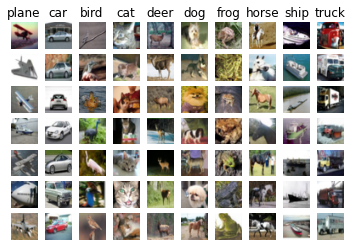

In [ ]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
# Subsample the data for more efficient code execution in this notebook
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


# K-nearest neighbors

In the following cells, we build a KNN classifier and choose hyperparameters via k-fold cross-validation.

In [ ]:
# Import the KNN class
from nndl import KNN

In [ ]:
# Declare an instance of the knn class.
knn = KNN()

# Train the classifier.
#   We have implemented the training of the KNN classifier.
#   Let us look at the train function in the KNN class to see what this does.
knn.train(X=X_train, y=y_train)

## Remarks

(1) In the function knn.train(), all the examples that are going to be processed are loaded in the memory : the images are stored in self.X_train and the associated labels are stored in y_train. This way, the algorithm "knows" where all the images are in the N dimensional space and knows the associated label with each image.

(2) The pros of this training step is mainly that it is simple and fast : the code is only two lines and easy to understand. However, the main disadvantage of this technique is that it requires loading all the images at once, which is memory intensive and causes long execution times. This process wouldn't even be possible on datasets with more images of greater size: it is not sustainable.

## KNN prediction

In the following sections, we will implement the functions to calculate the distances of test points to training points, and from this information, predict the class of the KNN.

In [ ]:
# We implement the function compute_distances() in the KNN class.
import time
time_start =time.time()

dists_L2 = knn.compute_distances(X=X_test)

print('Time to run code: {}'.format(time.time()-time_start))
print('Frobenius norm of L2 distances: {}'.format(np.linalg.norm(dists_L2, 'fro')))

Done
Time to run code: 42.47522473335266
Frobenius norm of L2 distances: 7906696.077040902


#### Really slow code

Note: 
This probably took a while. This is because we use two for loops.  We could increase the speed via vectorization, removing the for loops.

If implemented correctly, evaluating np.linalg.norm(dists_L2, 'fro') should return: ~7906696

### KNN vectorization

The above code took far too long to run.  If we wanted to optimize hyperparameters, it would be time-expensive.  Thus, we will speed up the code by vectorizing it, removing the for loops.

In [ ]:
# Let us implement the function compute_L2_distances_vectorized() in the KNN class.
# In this function, we will achieve the same L2 distance but WITHOUT any for loops.
# Note, this is SPECIFIC for the L2 norm.

time_start =time.time()
dists_L2_vectorized = knn.compute_L2_distances_vectorized(X=X_test)
print('Time to run code: {}'.format(time.time()-time_start))
print('Difference in L2 distances between your KNN implementations (should be 0): {}'.format(np.linalg.norm(dists_L2 - dists_L2_vectorized, 'fro')))

Time to run code: 1.3586325645446777
Difference in L2 distances between your KNN implementations (should be 0): 0.0


#### Speedup

Depending on your computer speed, you should see a 10-100x speed up from vectorization.

### Implementing the prediction

Now that we have functions to calculate the distances from a test point to given training points, we now implement the function that will predict the test point labels.

In [ ]:
# Let us implement the function predict_labels in the KNN class.
# We calculate the training error (num_incorrect / total_samples) 
#   from running knn.predict_labels with k=1

# Let us calculate the error rate by calling predict_labels on the test 
# data with k = 1 and store the error rate in the variable error.

def get_error(model, X_test, y_test, k, method, norm = None):
  error = 0
  dists = method(X_test, norm)
  predicted_labels = knn.predict_labels(dists, k)
  for i in range(X_test.shape[0]):
    error += 1 - int(predicted_labels[i] == y_test[i])
  error = error/X_test.shape[0]
  return error

error = get_error(knn, X_test, y_test, k = 1, method = knn.compute_L2_distances_vectorized)

print(error)

0.726


If you implemented correctly, the error should be: 0.726.

This means that the k-nearest neighbors classifier is right 27.4% of the time, which is not great, considering that chance levels are 10%.

# Optimizing KNN hyperparameters

In this section, we'll take the KNN classifier and perform cross-validation to choose a best value of $k$, as well as a best choice of norm.

### Create training and validation folds

First, we will create the training and validation folds for use in k-fold cross validation.

In [ ]:
# Create the dataset folds for cross-valdiation.
num_folds = 5

X_train_folds = []
y_train_folds =  []

# Splitting the training data into num_folds (i.e., 5) folds.
X_train_folds = [X_train[i:i + (X_train.shape[0]//num_folds)] for i in range(0, X_train.shape[0], (X_train.shape[0]//num_folds))]
y_train_folds = [y_train[i:i + (y_train.shape[0]//num_folds)] for i in range(0, y_train.shape[0], (y_train.shape[0]//num_folds))]



### Optimizing the number of nearest neighbors hyperparameter.

In this section, we select different numbers of nearest neighbors and assess which one has the lowest k-fold cross validation error.

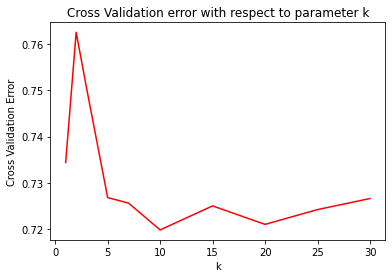

Computation time: 65.47


In [ ]:
time_start =time.time()

ks = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30]


# Let us calculate the cross-validation error for each k in ks, testing
# the trained model on each of the 5 folds.  

scores = []

for k in ks:
  error = []
  for fold_idx in range(num_folds):  # selecting the current fold
    dataX = X_train_folds.copy()  
    datay = y_train_folds.copy()
    X_valid = np.array(dataX.pop(fold_idx))  # selecting our validation data as the current fold
    y_valid = np.array(datay.pop(fold_idx))
    X_tr = np.reshape(np.array(dataX), (-1, np.shape(np.array(dataX))[2]))  # removing the validation fold from the data
    y_tr = np.reshape(np.array(datay), (np.shape(np.array(datay))[0]*np.shape(np.array(datay))[1]))

    knn.train(X_tr, y_tr)  # training on the remaining data
    error.append(get_error(knn, X_valid, y_valid, k, method = knn.compute_L2_distances_vectorized))  # evaluating on the validation data
  scores.append(np.mean(error))


plt.figure(1)
plt.plot(ks, scores, color = 'red')
plt.title('Cross Validation error with respect to parameter k')
plt.xlabel('k')
plt.ylabel('Cross Validation Error')
plt.show()

print('Smallest cross validation error is {}, obtained for k = {}'.format(min(scores), ks[np.argmin(scores)]))

print('Computation time: %.2f'%(time.time()-time_start))

## Analizing the results

(1) The best value of k is 10.

(2) The cross-validation error for this value of k is 0.7198

### Optimizing the norm

Next, we test three different norms (the 1, 2, and infinity norms) and see which distance metric results in the best cross-validation performance.

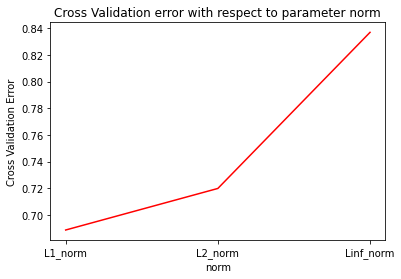

Smallest cross validation error is 0.6886000000000001, obtained for norm = 1
Computation time: 868.58


In [ ]:
time_start =time.time()

L1_norm = lambda x: np.linalg.norm(x, ord=1)
L2_norm = lambda x: np.linalg.norm(x, ord=2)
Linf_norm = lambda x: np.linalg.norm(x, ord= np.inf)
norms = [L1_norm, L2_norm, Linf_norm]

# Let us Calculate the cross-validation error for each norm in norms, testing
# the trained model on each of the 5 folds.
k = 10
scores = []
for norm in norms:
  error = []
  for fold_idx in range(num_folds):  # selecting the current fold
    dataX = X_train_folds.copy()  
    datay = y_train_folds.copy()
    X_valid = np.array(dataX.pop(fold_idx))  # selecting our validation data as the current fold
    y_valid = np.array(datay.pop(fold_idx))
    X_tr = np.reshape(np.array(dataX), (-1, np.shape(np.array(dataX))[2]))  # removing the validation fold from the data
    y_tr = np.reshape(np.array(datay), (np.shape(np.array(datay))[0]*np.shape(np.array(datay))[1]))

    knn.train(X_tr, y_tr)  # training on the remaining data
    error.append(get_error(knn, X_valid, y_valid, k, method = knn.compute_distances, norm = norm))  # evaluating on the validation data
  scores.append(np.mean(error))

norms_txt = ['L1_norm', 'L2_norm', 'Linf_norm']
plt.figure(1)
plt.plot(norms_txt, scores, color = 'red')
plt.title('Cross Validation error with respect to parameter norm')
plt.xlabel('norm')
plt.ylabel('Cross Validation Error')
plt.show()

print('Smallest cross validation error is {}, obtained for norm = {}'.format(min(scores), norms_txt[np.argmin(scores)]))

print('Computation time: %.2f'%(time.time()-time_start))

## Results

(1) The l1 norm has the best cross-validation error.

(2) For k = 10 and the L1 norm, the cross-validation error obtained is 0.6886

# Evaluating the model on the testing dataset.

Now, given the optimal $k$ and norm we found in earlier parts, let us evaluate the testing error of the k-nearest neighbors model.

In [ ]:
error = 1

# Let us Evaluate the testing error of the k-nearest neighbors classifier
# for our optimal hyperparameters found by 5-fold cross-validation.

k = 10
norm = norms[0]
knn.train(X_train, y_train)
error = get_error(knn, X_test, y_test, k, method = knn.compute_distances, norm = norm)


print('Error rate achieved: {}'.format(error))

Error rate achieved: 0.722
